In [1]:
%matplotlib inline
from fastai.basics import *

## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

In [17]:
!mkdir data/mnist

In [18]:
!rm data/mnist.pkl.gz

In [19]:
!wget http://deeplearning.net/data/mnist/mnist.pkl.gz -O data/mnist/mnist.pkl.gz

--2019-01-03 20:09:52--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘data/mnist/mnist.pkl.gz’

data/mnist/mnist.pk 100%[===================>]  15.42M  4.11MB/s    in 4.1s    

2019-01-03 20:09:56 (3.74 MB/s) - ‘data/mnist/mnist.pkl.gz’ saved [16168813/16168813]



In [20]:
path = Path('data/mnist')

In [21]:
path.ls()

[PosixPath('data/mnist/mnist.pkl.gz')]

In [22]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

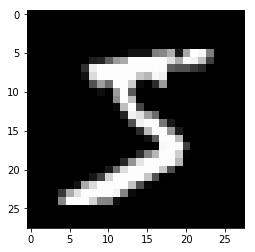

In [23]:
plt.imshow(x_train[0].reshape((28,28)), cmap='gray')
x_train.shape

In [24]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))

In [28]:
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [29]:
bs = 64

In [34]:
train_ds = TensorDataset(x_train, y_train) # PyTorch dataset wrapping tensors.
valid_ds = TensorDataset(x_valid, y_valid)

In [39]:
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [42]:
x,y = next(iter(data.train_dl))

In [43]:
x.shape, y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [49]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)
        
    def forward(self, xb): return self.lin(xb) # xb is a batch of X

In [50]:
model = Mnist_Logistic().cuda()

In [51]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [52]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [53]:
model(x).shape

torch.Size([64, 10])

In [54]:
# Sanity check
for param in model.parameters():
    print(type(param.data), param.size())

<class 'torch.Tensor'> torch.Size([10, 784])
<class 'torch.Tensor'> torch.Size([10])


In [55]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [56]:
lr = 2e-2

In [57]:
loss_func = nn.CrossEntropyLoss() # combines Log Softmax and NLL loss

In [62]:
def update(x, y, lr):
    wd = 1e-5 # new
    y_hat = model(x) # was y_hat = x@a
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd # was mse(y, y_hat)
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad) # was a.sub_(lr * a.grad)
            p.grad.zero_() # was a.grad.zero_()
    return loss.item()

In [63]:
losses = [update(x, y, lr) for x, y in data.train_dl]

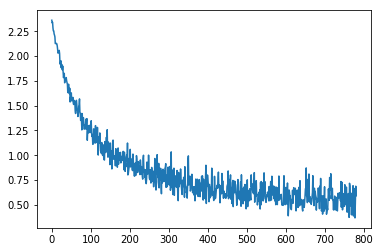

In [66]:
plt.plot(losses)

In [67]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)
        
    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x) # add non-linearities
        return self.lin2(x)

In [68]:
model = Mnist_NN().cuda()

In [69]:
losses = [update(x, y, lr) for x, y in data.train_dl]

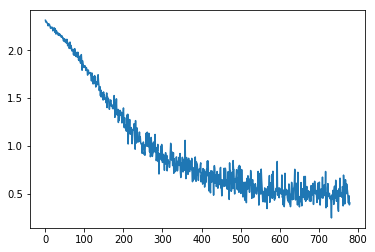

In [70]:
plt.plot(losses)

In [71]:
model = Mnist_NN().cuda()

In [72]:
def update(x, y, lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [73]:
losses = [update(x, y, 1e-3) for x, y in data.train_dl]

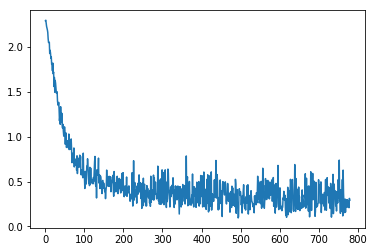

In [74]:
plt.plot(losses)

In [75]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


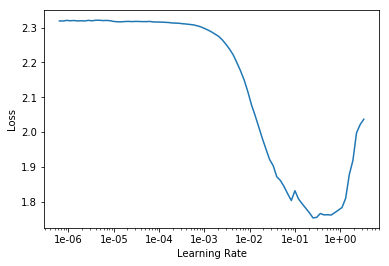

In [76]:
learn.lr_find()
learn.recorder.plot()

In [77]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.142047,0.127680,0.963500


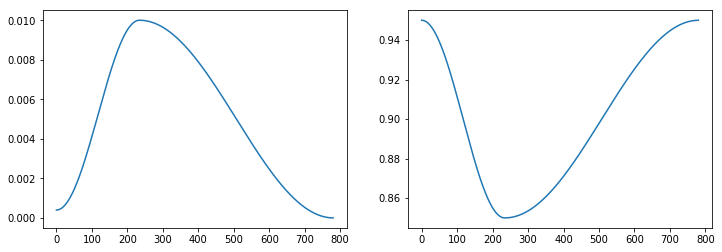

In [78]:
learn.recorder.plot_lr(show_moms=True)

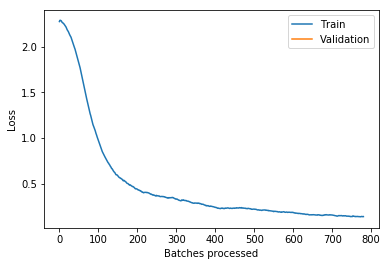

In [79]:
learn.recorder.plot_losses()